<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Launch New Products

Today you are a machine learning engineer at the Department of New Products at Target Cosmetics! 

We will start with a small dataset on interactions between users and current products from the past and try to discover substructure, if there's any, by applying some **unsupervised learning** methods. 

Then we will leverage the small amount of labeled data (current products) in combination with a larger amount of unlabeled data (new products to launch) to make estimations as to which products with sell more. 

## Learning Objectives

By the end of this session, you will be able to:

- apply dimensionality reduction techniques to reduce features to a lower dimensional space
- perform customer segmentation, determine optional number of clusters, and understand assumptions for used algorithm
- understand what semi-supervised learning is and leverage it to improve performance of supervised learning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Task 1. Dimensionality Reduction

1. Load in the data. 
    
    Import `pandas` as `pd` and use `pd.read_csv()` to read in `past.csv.gz` in the `dat` folder, saving it as `past`. 
    
    Data in `past.csv.gz` was propcessed; e.g., features indicating time of day, day of week, month, and year of the purchase have been converted to one-hot representations of these categories. 

In [3]:
# YOUR CODE HERE
past = pd.read_csv(filepath_or_buffer='../dat/past.csv.gz')


In [4]:
past.columns

Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')

In [5]:
past.head()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category
0,5866936,5.618978e+08,1.333333,1.333333,5550.000,15.84000,15.84000,0.00,1.333333,0.00,...,0.00,0.000,0.0,0.666667,0.333333,0.00,0.00,0,0.00,1.0
1,5647110,5.326529e+08,2.250000,1.500000,27556.500,5.80000,5.56500,1.25,0.250000,0.25,...,0.25,0.750,0.0,0.000000,0.250000,0.00,0.00,0,0.00,1.0
2,5790472,4.578109e+08,1.000000,1.000000,0.000,6.27250,6.27250,0.25,0.750000,0.00,...,0.00,0.000,0.0,0.000000,0.750000,0.25,0.00,0,0.00,1.0
3,5811598,4.612641e+08,1.500000,1.500000,131532.500,5.56000,5.56000,0.25,1.000000,0.25,...,0.25,0.000,0.0,0.000000,0.500000,0.00,0.25,0,0.25,1.0
4,5846363,5.157993e+08,1.875000,1.375000,11055.875,4.08625,4.08625,0.50,1.000000,0.25,...,0.25,0.375,0.0,0.125000,0.250000,0.25,0.00,1,0.00,1.0


<details>
<summary> Expected output </summary>

```
Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')
```
</details>

2. What percentage of the interactions (rows) resulted in a purchase?

    `34.38 % of rows in the dataset result in a purchase`.
    
    Do people mostly buy what they look at or do they do a lot of "window shopping" (shopping around without buying)?

    `Using *groupby()* method for column *Purchase?* and calculate mean() of *NumView* shows us that people mostly make decision to buy or not to buy when they look at.`

    From the classification perspective, is the data balanced?
    
    `The percentage of class 1 is 34.38% and class 0 is 65.62% seems to be balanced in term of classificaiton task.`

In [6]:
# YOUR CODE HERE .3448
print(f"The Percentage of purchase in dataset: {past['Purchased?'].mean():%}")


The Percentage of purchase in dataset: 34.380000%


Show a reduced dataset relating to number of views:

In [7]:
past.loc[:, ['NumOfEventsInJourney', 'InsessionView', 'NumView']].head()

,NumOfEventsInJourney,InsessionView,NumView
0,1.333333,1.000,1.333333
1,2.250000,2.250,0.250000
2,1.000000,30.000,0.750000
3,1.500000,10.500,1.000000
4,1.875000,3.375,1.000000


Using `groupby` method to calculate the mean of each these columns:

In [8]:
past.groupby(by=["Purchased?"])['NumOfEventsInJourney', 'InsessionView', 'NumView'].mean()

,NumOfEventsInJourney,InsessionView,NumView
Purchased?,,,
0,1.872303,15.644532,0.880742
1,2.101440,15.274447,0.918394


3. Drop `product_id` and `user_id` and save the rest columns to a new `pd.DataFrame`:`X`; then pop the column `'Purchased?'` and save it to `y`.

In [9]:
# YOUR CODE HERE
X = past.drop(columns=["product_id", "user_id"])
# YOUR CODE HERE
y = X.pop("Purchased?")

In [10]:
assert X.shape == (5000, 34)
assert y.shape == (5000,)
print("Shape is as expected!")

Shape is as expected!


4. Apply [PCA (check documentation if unfamiliar)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the number of features down to **5**, save it to an numpy array named `X_reduced`. 

    Do you need to preprocess the data before performing PCA? Quick review [here: Importance of feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html).
    
    If time permits, read [Does mean centering or feature scaling affect a Principal Component Analysis?](https://sebastianraschka.com/faq/docs/pca-scaling.html) or [discussion 1](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance).

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. 
The input data is centered but not scaled for each feature before applying the SVD.

So, with PCA, scaling data is not necessary due to it will change the center of the each feature then, the result will be different.
The main idea of PCA is reduce the size of original dataset but still keep the its information. The minimum information required to keep will depend on task but typically is 95%. This value will guide to select the right number of pca components for transformation.

In [27]:
# YOUR CODE HERE
from sklearn.preprocessing import Normalizer, StandardScaler, scale
from sklearn.decomposition import PCA
#scaler = StandardScaler()
#X1 = scaler.fit_transform(X)
pca = PCA(n_components=5, random_state=0)
X_reduced = pca.fit_transform(X)

In [28]:
assert X_reduced.shape == (5000, 5)

5. Print out the percentage of variance explained by each of the selected components.

In [29]:
# YOUR CODE HERE
print(f"The percentage of variance of pca components: {pca.explained_variance_ratio_*100}")
print(f"Total percentage of information of pca components compare to raw dataset: {sum(pca.explained_variance_ratio_*100)}")

The percentage of variance of pca components: [9.99999964e+01 2.47265791e-06 6.07892712e-07 4.46411179e-07
 5.83762094e-08]
Total percentage of information of pca components compare to raw dataset: 99.99999999894085


So, the first element of pca bring almost 100% information from dataset. Other elements bring less information.

Let's check with scaled data:

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X1 = scaler.fit_transform(X)
pca2 = PCA(n_components=5, random_state=0)
X_reduced2 = pca2.fit_transform(X1)
print(f"The percentage of variance of pca components: {pca2.explained_variance_ratio_*100}")
print(f"Total percentage of information of pca components compare to raw dataset: {sum(pca2.explained_variance_ratio_*100)}")


The percentage of variance of pca components: [24.54054558  7.51571136  7.13500951  6.91504181  6.09323096]
Total percentage of information of pca components compare to raw dataset: 52.199539212783776


So, Applying scaling and n_components=5 for PCA will drop the information from raw dataset, we loss 48% infromation from raw dataset. 
The minimum number of components to keep the information above 95% will be studied below.

In [32]:
pca3 = PCA(n_components=0.95, random_state=0)
X_reduced3 = pca3.fit_transform(X1)
print(f"Original dataset features are: {X.shape[1]}")
print(f"Minimum number of components to keep at least 95% information: {len(pca3.explained_variance_ratio_)}")
print(f"Total percentage of information of pca components compare to raw dataset: {sum(pca3.explained_variance_ratio_*100)}")


Original dataset features are: 34
Minimum number of components to keep at least 95% information: 15
Total percentage of information of pca components compare to raw dataset: 96.04029405170812


6. Review code in functions `visualize_2pcs` and `visualize_3pcs` below and visualize first few principal components in 2D and 3D plots, respectively:

In [56]:
import matplotlib.pyplot as plt

def visualize_2pcs(pcs, y):
    fig, ax = plt.subplots()
    plot = plt.scatter(pcs[:,0], pcs[:,1], c=y) 
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

In [57]:
def visualize_3pcs(pcs, y):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(projection='3d')
    plot = ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=y)
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

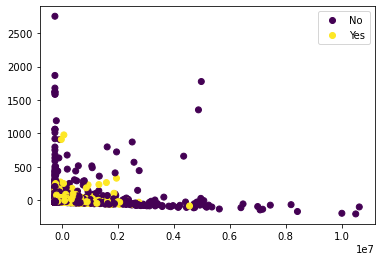

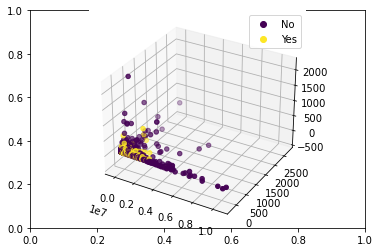

In [58]:
# YOUR CODE HERE
visualize_2pcs(X_reduced, y)
# YOUR CODE HERE
visualize_3pcs(X_reduced, y)

7. One way to assess the quality of the dimensionality reduction, when the groundtruth is available of course, is comparing the prediction performance using given features vs reduced (engineered) features.

    Complete the wrapper function below that 

    - takes features, target, and a boolean parameter indicating whether to include standardization in the pipeline or not
    - split the data into train (80%) and test (20%) datasets, set the random state for spliting at 0
    - build a pipeline that 

        1) preprocessing data using standardization if the `standardize` is `True`; otherwise skip this step  

        2) apply logistic regression ( do you consider data is balanced? )
        
    - fit the pipeline using training data
    - print the classification report (use `sklearn.metrics.classification_report`) on test data

In [66]:
# YOUR CODE HERE (imports!)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def train(X, y, standardize = True) -> None:
    # YOUR CODE HERE
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
    if standardize == True:
        logistic_reg = Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("logistic", LogisticRegression(C=1, class_weight='balanced', random_state=0))
            ]
        )
    else:
        logistic_reg = LogisticRegression(C=1, class_weight='balanced', random_state=0)
      
    logistic_reg.fit(X_train, y_train)

    return y_test, logistic_reg.predict(X_test)

y_true, y_preds = train(X, y, standardize=True)


Now apply the pipeline on the all the features `X` and review the performance

In [67]:
# YOUR CODE HERE
from sklearn.metrics import classification_report
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       649
           1       0.55      0.52      0.54       351

    accuracy                           0.68      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.68      0.68      0.68      1000



Similarly, apply the pipeline on the reduced / engineered features `X_reduced`. Should you include standardization in the pipeline?

It seems to be applied standardization for reduced dataset make it easier for classifiers to do the job. 

In [68]:
# YOUR CODE HERE
y_true, y_preds = train(X_reduced, y, standardize=None)
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80       649
           1       0.65      0.44      0.52       351

    accuracy                           0.72      1000
   macro avg       0.69      0.65      0.66      1000
weighted avg       0.71      0.72      0.70      1000



In [69]:
# YOUR CODE HERE
y_true, y_preds = train(X_reduced, y, standardize=True)
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.76      0.88      0.81       649
           1       0.67      0.48      0.56       351

    accuracy                           0.74      1000
   macro avg       0.72      0.68      0.69      1000
weighted avg       0.73      0.74      0.72      1000



In [13]:
# YOUR CODE HERE


              precision    recall  f1-score   support

           0       0.74      0.70      0.72       649
           1       0.49      0.54      0.51       351

    accuracy                           0.64      1000
   macro avg       0.61      0.62      0.62      1000
weighted avg       0.65      0.64      0.65      1000



8. Are the results as expected? Discuss the pros and cons using reduced set of features in this application with your teammate. 
    *YOUR ANSWER HERE*

    The accuracy of model when applying PCA is higher than the raw data (more than 10% improvement). The precision and recall score for class 1 is significantly improved when apply PCA.
    

## Task 2. Customer Segmentation

In this task, we apply k-means clustering on the reduced data, experimenting different vaules of `n_cluster`, summarize all this information in a single plot, the *Elbow* plot. In addition, leverage silhouette visualization to help decide the "optimal" number of clusters in our data and answer: 

1. Are there any patterns among customer purchasing behaviors?
2. If so, what categories do they belong to? How do you characterize the clusters?
3. If not, what followup steps and / or recommendations will you make as an MLE?

1. Look up the [documentation](https://scikit-learn.org/stable/modules/clustering.html) and import the model class for k-means from `sklearn.cluster`

In [72]:
# YOUR CODE HERE
from sklearn.cluster import KMeans


2. Complete `visualize_elbow`; inspect the code and complete

    - fit k-means on the given data `X` and `k`, setting `random_state` to be 10 for reproducibility
    - append the sum of squared distances of samples to their closest cluster center for each $k$ to list `inertias`

In [73]:
def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    for k in ks:
        # YOUR CODE HERE
        kmeans = KMeans(n_clusters=k, random_state=10)
        kmeans.fit(X_reduced)
        # YOUR CODE HERE
        inertias.append(kmeans.inertia_)
        
    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')

3. Visualize the elbow plot for the number of clusters ranging between 2 and 9. Discuss with your teammate, what is the 'optimal' number of clusters?

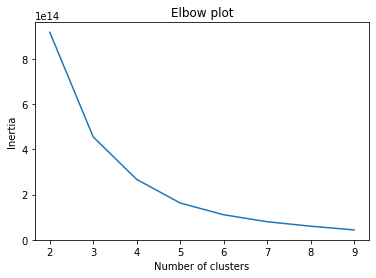

In [74]:
ks = range(2, 10)
visualize_elbow(X_reduced, ks)

The optimal number of cluster is 3 because we see a quick change in inerteria.

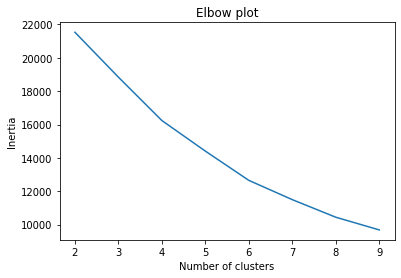

In [16]:
# YOUR CODE HERE

4. What are the disadvantage to use the Elbow method? 

    *YOUR ANSWER HERE*

    Elbow method is not so clear in some cases and can lead to misinterpret.

5. Let's try a different approach: [silhouette score](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6).

    A helper function `visualize_silhouette` is provided for you (inspect the code in `utils.py`) and figure out how to use it to visualize k-means for k ranges from 2 to 8 on the reduced data. 

In [75]:
from utils import visualize_silhouette

For n_clusters = 2 The average silhouette_score is : 0.8993912369985677
For n_clusters = 3 The average silhouette_score is : 0.8301330443648314
For n_clusters = 4 The average silhouette_score is : 0.7978269670927682
For n_clusters = 5 The average silhouette_score is : 0.7949254112563352
For n_clusters = 6 The average silhouette_score is : 0.7888707267319567
For n_clusters = 7 The average silhouette_score is : 0.7782579514988627
For n_clusters = 8 The average silhouette_score is : 0.779012764676448
For n_clusters = 9 The average silhouette_score is : 0.7699354751986033


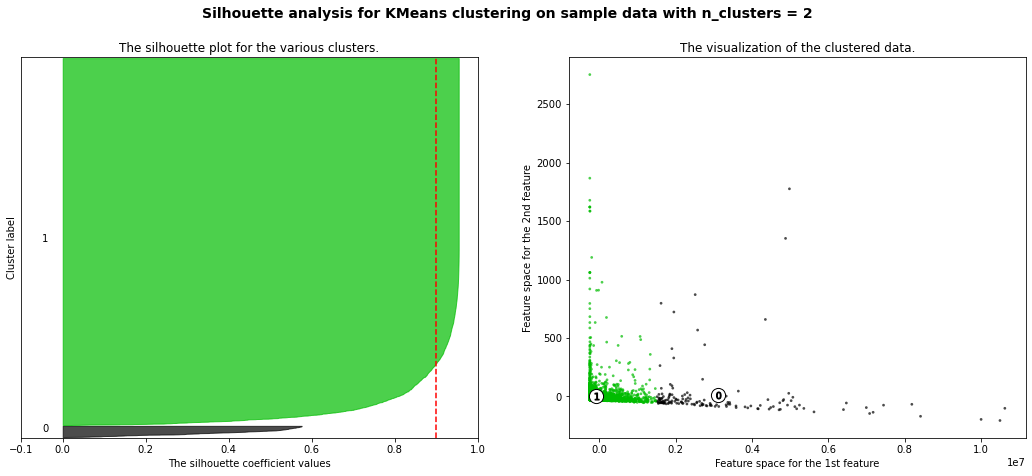

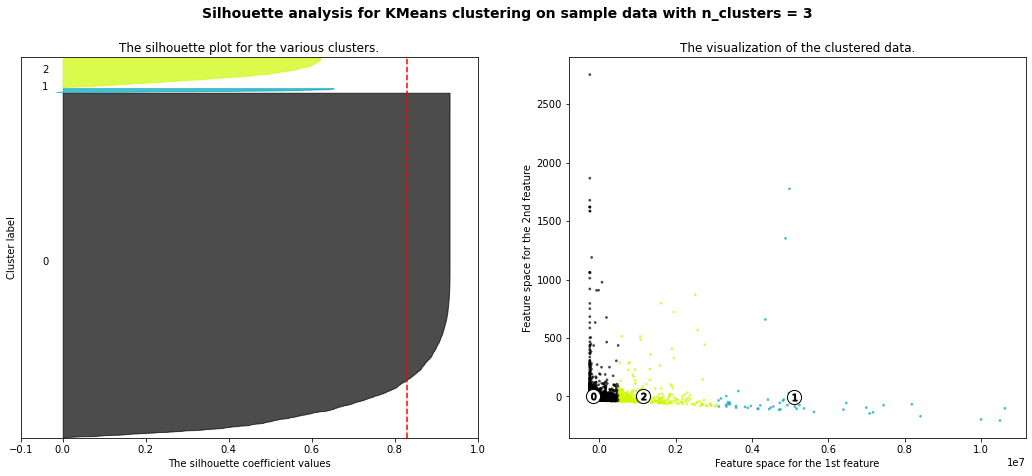

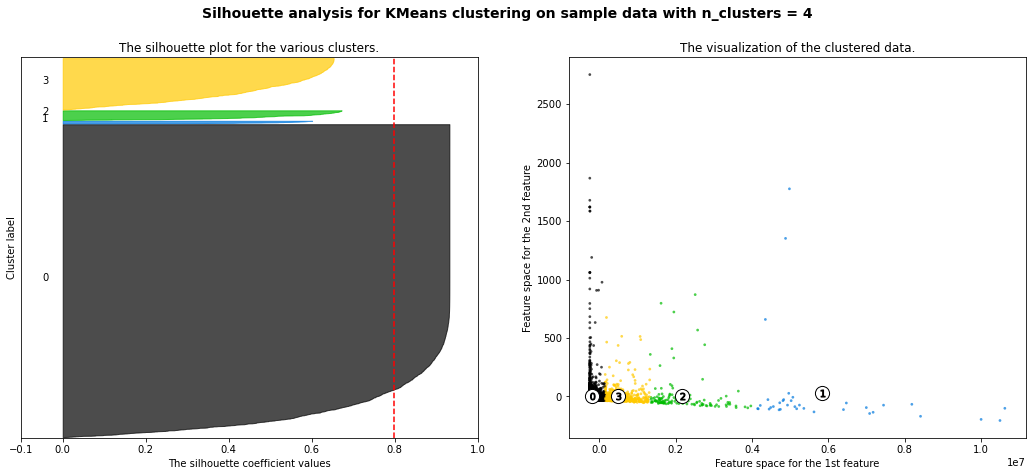

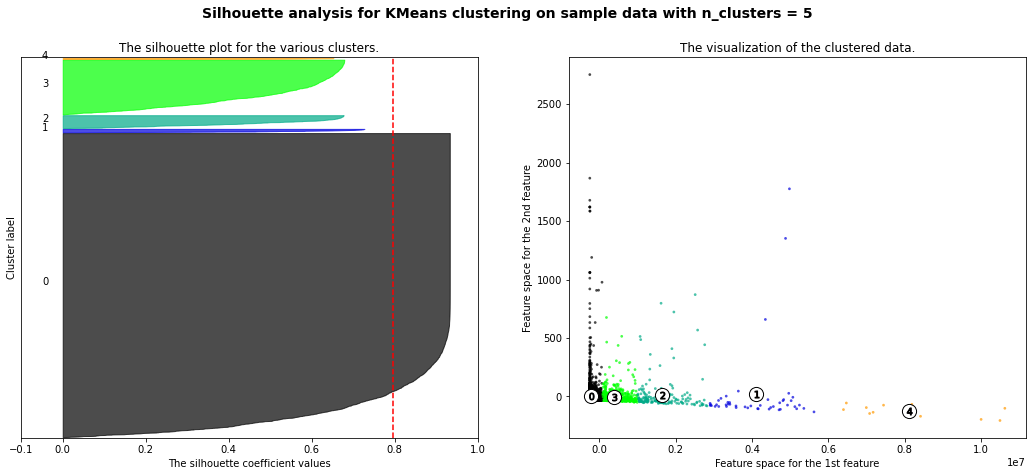

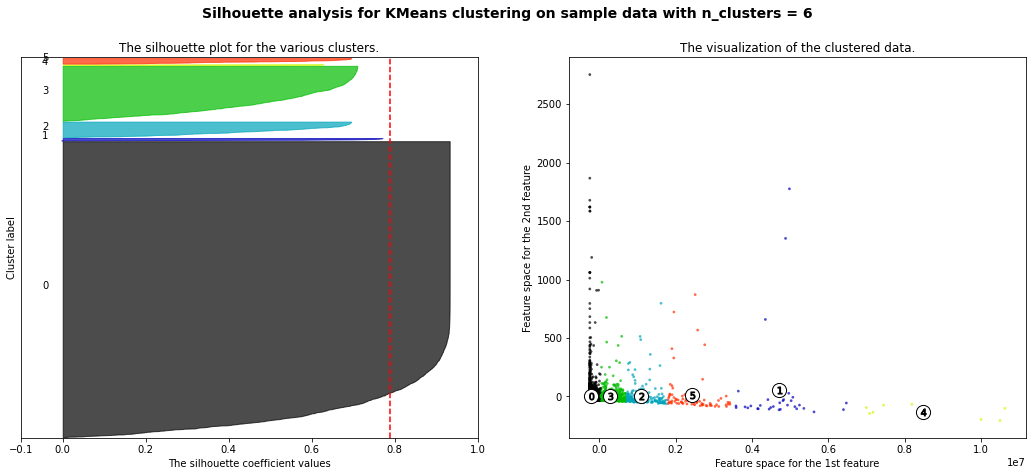

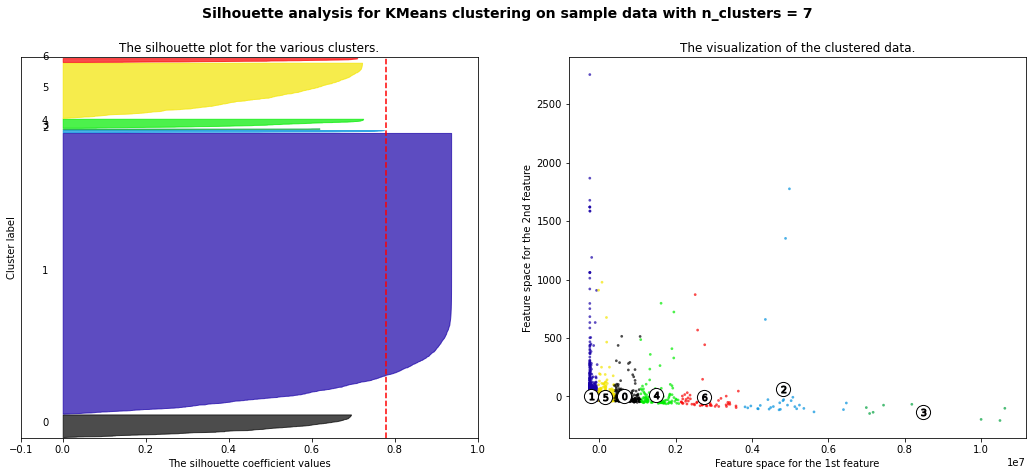

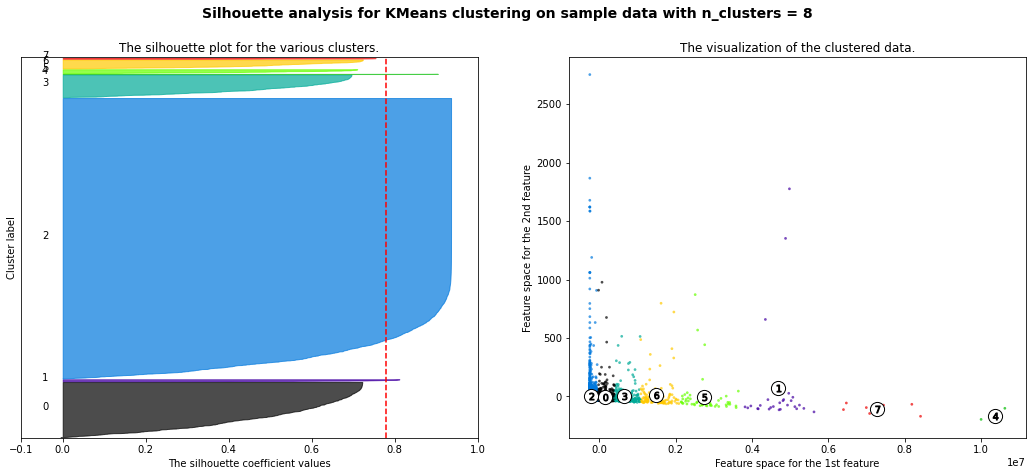

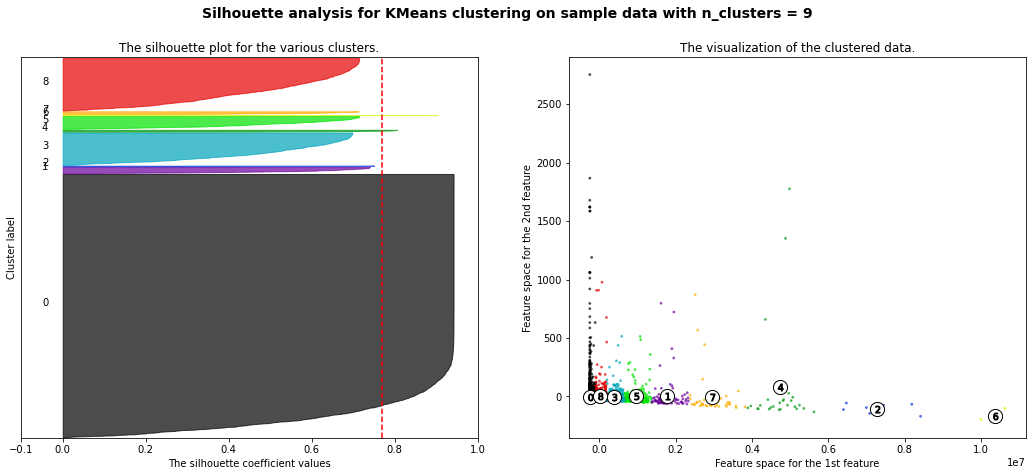

In [77]:
visualize_silhouette(max_clusters=9, X=X_reduced)

For n_clusters = 2 The average silhouette_score is : 0.19919967382453047
For n_clusters = 3 The average silhouette_score is : 0.21238428422148908
For n_clusters = 4 The average silhouette_score is : 0.21846259845030108
For n_clusters = 5 The average silhouette_score is : 0.2055016602111605
For n_clusters = 6 The average silhouette_score is : 0.20861307391519884
For n_clusters = 7 The average silhouette_score is : 0.2137422138377995
For n_clusters = 8 The average silhouette_score is : 0.21817268912132334


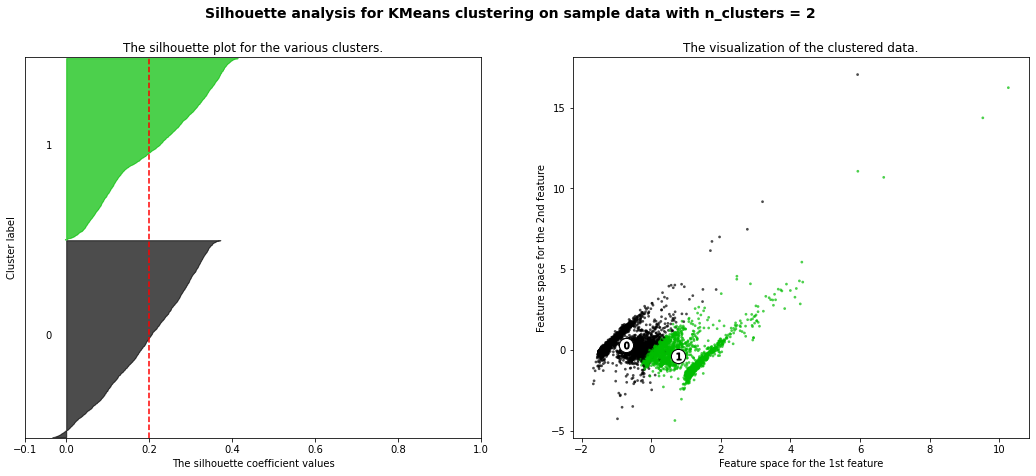

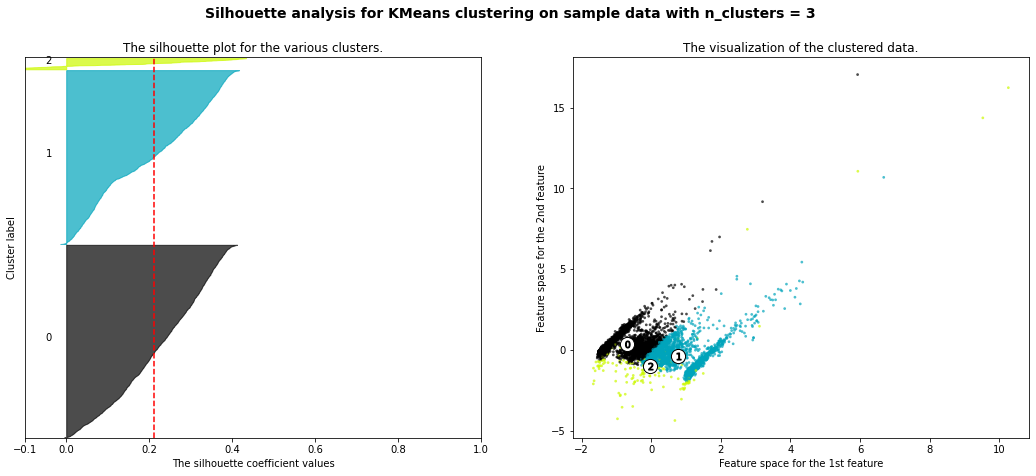

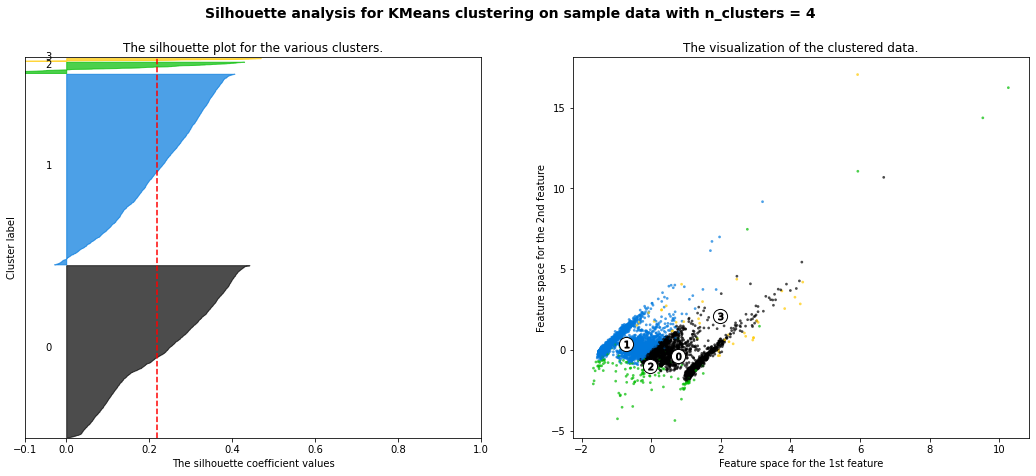

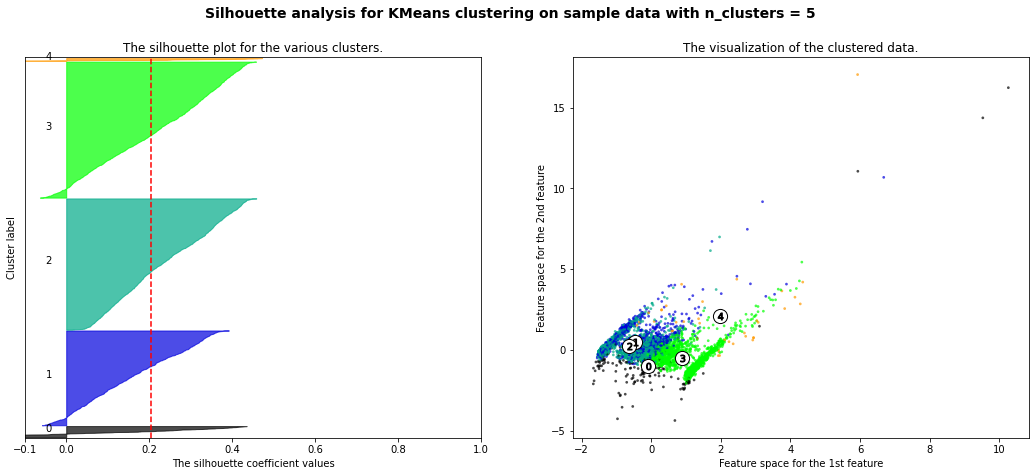

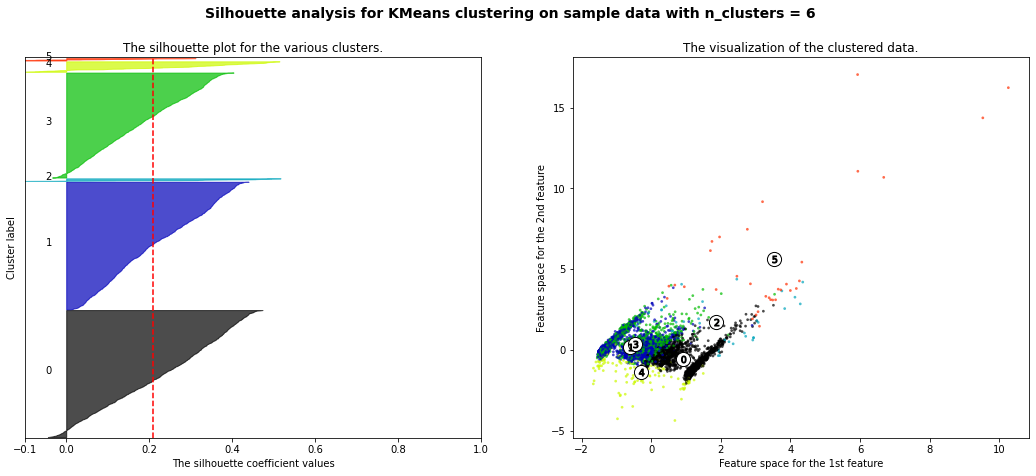

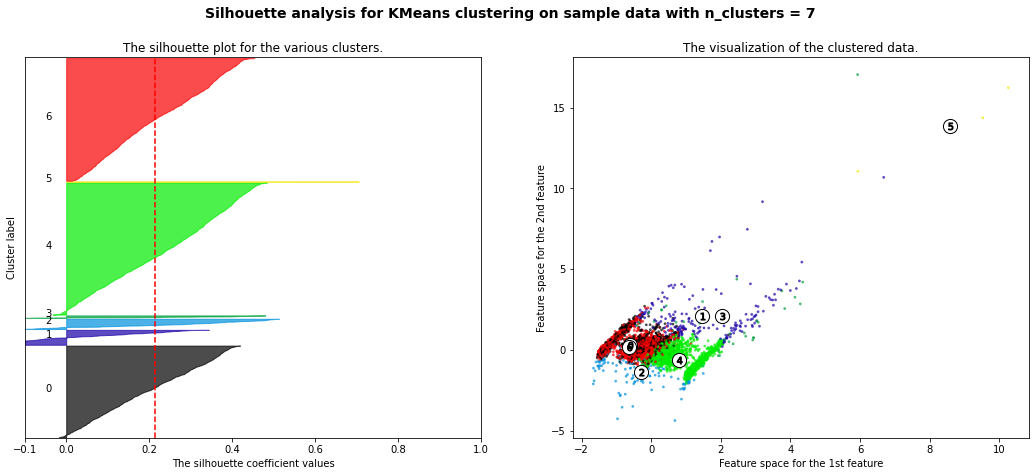

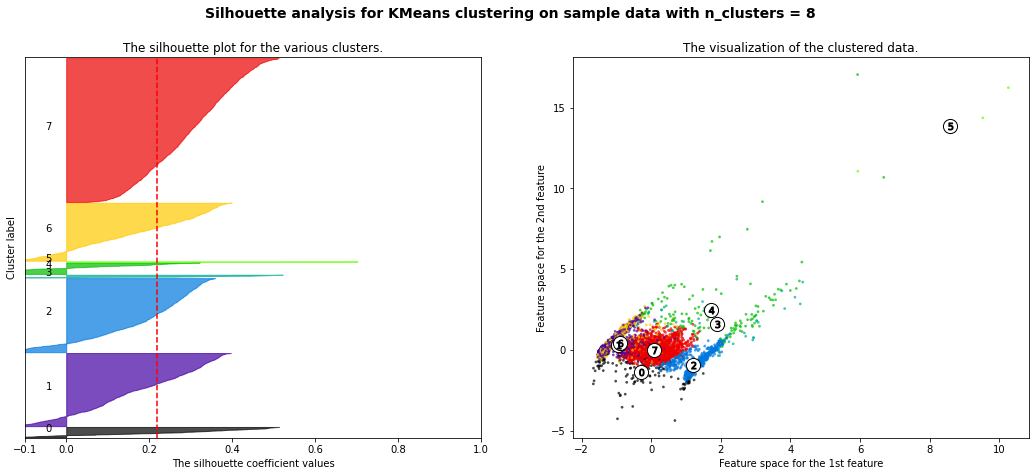

In [18]:
# YOUR CODE HERE

6. Instantiate a k-mean model using the number of cluster that you deem optimal, assign it to `km`, and fit on the reduced data. 

In [90]:
# YOUR CODE HERE
km = KMeans(n_clusters=3, random_state=10)
km.fit(X_reduced)


KMeans(n_clusters=3, random_state=10)

7. What is the size of each cluster? 

In [103]:
# YOUR CODE HERE
preds = km.predict(X_reduced)
uniques, counts = np.unique(preds, return_counts=True)
cluster_counts = dict(zip(uniques, counts))
print("The size of each cluster: ")
for i in range(len(uniques)):
    print(f"Cluster {i}: {cluster_counts[i]}")


The size of each cluster: 
Cluster 0: 4561
Cluster 1: 51
Cluster 2: 388


8. Create a new column called `cluster_pca` in `past`, with values as predicted cluster index predicted by `km`. 

In [93]:
# YOUR CODE HERE
past["cluster_pca"] = preds
past.head()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
0,5866936,5.618978e+08,1.333333,1.333333,5550.000,15.84000,15.84000,0.00,1.333333,0.00,...,0.000,0.0,0.666667,0.333333,0.00,0.00,0,0.00,1.0,0
1,5647110,5.326529e+08,2.250000,1.500000,27556.500,5.80000,5.56500,1.25,0.250000,0.25,...,0.750,0.0,0.000000,0.250000,0.00,0.00,0,0.00,1.0,0
2,5790472,4.578109e+08,1.000000,1.000000,0.000,6.27250,6.27250,0.25,0.750000,0.00,...,0.000,0.0,0.000000,0.750000,0.25,0.00,0,0.00,1.0,0
3,5811598,4.612641e+08,1.500000,1.500000,131532.500,5.56000,5.56000,0.25,1.000000,0.25,...,0.000,0.0,0.000000,0.500000,0.00,0.25,0,0.25,1.0,0
4,5846363,5.157993e+08,1.875000,1.375000,11055.875,4.08625,4.08625,0.50,1.000000,0.25,...,0.375,0.0,0.125000,0.250000,0.25,0.00,1,0.00,1.0,0


9. Open ended: manipulate `past` and see if you can characterize each cluster (e.g., calculate statistics of / visualize features for each cluster), how will you intepret the results? 

    **Note**. This is probably the most important part as far as the business stakeholders are concerned: "*What can I do with your results?*" The math, modeling part is relatively easy, compared to actionable recommendations you make for business. Thus, before jumping on a different algorithm for the given task, do you best to 1) understand the data in depth 2) keep buisiness use cases in mind throughout all steps. 

In [ ]:
# YOUR CODE HERE

In [96]:
past.groupby(by="cluster_pca")["Purchased?"].mean()

cluster_pca
0    0.337207
1    0.019608
2    0.463918
Name: Purchased?, dtype: float64

In [107]:
past.groupby(by="cluster_pca")["NumView"].mean()

cluster_pca
0    0.870816
1    1.774510
2    1.046752
Name: NumView, dtype: float64

    *YOUR ANSWER HERE*

We found that the most purchase is in cluster 0 and cluster 2. Only 2% of user in cluster 2 made purchase. 
On the other hand, average number of view of users are in cluster 0 and 2 (less than 1.) also less  than the cluster 1. This figure is inline with previous analysis based on the NumView and tendency to buy.

10. What are the assumptions for k-means? Judging by the cluster sizes, is k-means a good approach? 

    Scanning the list of [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html) implemented in scikit-learn, try at least one other algorithm, examine its assumptions, and intepret results.

    *YOUR ANSWER HERE*

 K-Means clustering method considers two assumptions regarding the clusters – first that the clusters are spherical and second that the clusters are of similar size. 
 Spherical assumption helps in separating the clusters when the algorithm works on the data and forms clusters. If this assumption is violated, the clusters formed may not be what one expects. 
 On the other hand, assumption over the size of clusters helps in deciding the boundaries of the cluster. This assumption helps in calculating the number of data points each cluster should have. 
 This assumption also gives an advantage. Clusters in K-means are defined by taking the mean of all the data points in the cluster. With this assumption, one can start with the centers of clusters anywhere. 
 Keeping the starting points of the clusters anywhere will still make the algorithm converge with the same final clusters as keeping the centers as far apart as possible. 
 
The KMeans algorithm requires the number of clusters to be specified. It divides a set of N samples X into K disjoint clusters C, each described by the mean μj of the samples in the cluster. 
The means are commonly called the cluster “centroids”; note that they are not, in general, points from X, although they live in the same space.

`As the cluster size from KMeans is not equal [ cluster 0: 4561, cluster 1: 51, cluster 2: 388], KMeans might not be a good approach for this case`.

Let's try another method from sklearn:

In [154]:
# YOUR CODE HERE
from sklearn.cluster import DBSCAN, AffinityPropagation

dbscan = DBSCAN(eps=5, min_samples=10)
dbscan.fit(X_reduced)

#affprop = AffinityPropagation()
#affprop.fit_predict(X_reduced)

uniques, counts = np.unique(dbscan.labels_, return_counts=True)
cluster_counts = dict(zip(uniques, counts))
print("The size of each cluster: ")
for i in uniques.tolist():
    print(f"Cluster {i}: {cluster_counts[i]}")

The size of each cluster: 
Cluster -1: 3954
Cluster 0: 1024
Cluster 1: 22


In [150]:
# second pca
past["dbscan_pca"] = dbscan.labels_
past.head()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca,dbscan_pca
0,5866936,5.618978e+08,1.333333,1.333333,5550.000,15.84000,15.84000,0.00,1.333333,0.00,...,0.0,0.666667,0.333333,0.00,0.00,0,0.00,1.0,0,-1
1,5647110,5.326529e+08,2.250000,1.500000,27556.500,5.80000,5.56500,1.25,0.250000,0.25,...,0.0,0.000000,0.250000,0.00,0.00,0,0.00,1.0,0,-1
2,5790472,4.578109e+08,1.000000,1.000000,0.000,6.27250,6.27250,0.25,0.750000,0.00,...,0.0,0.000000,0.750000,0.25,0.00,0,0.00,1.0,0,-1
3,5811598,4.612641e+08,1.500000,1.500000,131532.500,5.56000,5.56000,0.25,1.000000,0.25,...,0.0,0.000000,0.500000,0.00,0.25,0,0.25,1.0,0,-1
4,5846363,5.157993e+08,1.875000,1.375000,11055.875,4.08625,4.08625,0.50,1.000000,0.25,...,0.0,0.125000,0.250000,0.25,0.00,1,0.00,1.0,0,-1


In [151]:
past.groupby(by="dbscan_pca")["Purchased?"].mean()

dbscan_pca
-1    0.425898
 0    0.034180
 1    0.000000
Name: Purchased?, dtype: float64

In [152]:
past.groupby(by="dbscan_pca")["NumView"].mean()

dbscan_pca
-1    0.896520
 0    0.880706
 1    0.988636
Name: NumView, dtype: float64

11. Jot down recommendations or followup steps, detailing the reasons.

    *YOUR ANSWER HERE*
    According to DBSCAN method, dataset is quite noisy (most labels are -1). Qick screening show that eps = 5 and min_samples = 10 is optimal values, the number of cluster is 3. When come up with statistical calculation, three cluster give us some very good information relating to purchase decision for cluster -1 and cluster 0. 

    Compare to KMeans, DBSCAN seem to be outperformed. But users need to tune eps and min_samples to get an approriate results. In short, DBSCAN is better than KMeans for this problem.


## Task 3. To launch or not to launch?

In this task, we will work on a hypothetical application: cosmetics purchase prediction for new products with limited features. The intention here is to maximize **recall** so that no popular cosmetic is understocked. Overstocking is less of a concern since it will not cause disengagement in customers.

The purchase status for each "new" product is known, but we only use the labels for benchmarking purpose. Instead, we use label spreading method to leverage a small amount of labeled data in combination with a larger amount of unlabeled data. 

1. Read in the data in `new.csv.gz` and save it as a `pd.DataFrame` named `new`. This is the test dataset.

    Look at the shape of `new` and inspect the frist few rows.

In [155]:
# YOUR CODE HERE
new = pd.read_csv(filepath_or_buffer='../dat/new.csv.gz')
new.shape

(30091, 5)

In [156]:
assert new.shape == (30091, 5)

In [157]:
new.head()

,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


2. How does the number of data points in the training set (`past`) compare to the number of datapoints in the test set (`new`)? 

    And how does the feature set in the training set compare to the feature set in the test set?

        *YOUR ANSWER HERE*

    *The number of datapoints in the training set is relatively small while the test set is quite large. The training set has more features than in the test set.*

3. Are there any product ids in both the training and test datasets? Hint: use `np.intersect1d` or set operations.

In [162]:
# YOUR CODE HERE
print(f"Number of product ids in both past and new data: {len(np.intersect1d(np.array(past['product_id']), np.array(new['product_id'])))}")


Number of product ids in both past and new data: 0


4. What percentage of data points resulted in a purchase in the test set?

    In reality, we won't be able to calculate information that is not available to you. Here, we simply demonstrated that the distributions in target between `past` and `new` are similar. 

In [165]:
# YOUR CODE HERE # ~.344
print(f'Percentage of data points in purchase: {new["Purchased?"].mean():%}')


Percentage of data points in purchase: 34.425576%


5. Create `ndarray`s: `X_train`, `y_train`, `X_test`, and `y_test` according to the following guidelines.

    - The `Purchased?` column is the target.
    - `X_train` and `X_test` should contain the same features
    - `product_id` should not be a feature.

    Double check that the shapes of the four arrays are what you expect.

In [166]:
# YOUR CODE HERE
# define features
features = [feature for feature in new.columns if feature not in ["Purchased?", "product_id"]]
labels = "Purchased?"

# Training set
X_train = past[features].values
y_train = past[labels].values

# Testing set
X_test  = new[features].values
y_test = new[labels].values


In [167]:
assert X_train.shape[0] == y_train.shape[0] # 5000
assert X_train.shape[1] == X_test.shape[1]  # 3

assert type(X_train) == np.ndarray # make sure you import numpy as np at this point
assert type(X_train).__module__ == type(y_train).__module__ == np.__name__  # alternative way

6. Let's fit a simple logistic regression on the training set (`X_train`, `y_train`) and report performance on the test set (`X_test`, `y_test`).

In [168]:
# YOUR CODE HERE
logistic_reg = LogisticRegression(class_weight="balanced",random_state=0)
logistic_reg.fit(X_train, y_train)
print(classification_report(y_test, logistic_reg.predict(X_test)))


              precision    recall  f1-score   support

           0       0.78      0.94      0.85     19732
           1       0.81      0.49      0.61     10359

    accuracy                           0.79     30091
   macro avg       0.80      0.72      0.73     30091
weighted avg       0.79      0.79      0.77     30091



In [31]:
# YOUR CODE HERE
logistic_reg = LogisticRegression(class_weight="balanced",random_state=0)
logistic_reg.fit(X_train, y_train)
print(classification_report(y_test, logistic_reg.predict(X_test)))


              precision    recall  f1-score   support

           0       0.78      0.94      0.85     19732
           1       0.81      0.49      0.61     10359

    accuracy                           0.79     30091
   macro avg       0.80      0.72      0.73     30091
weighted avg       0.79      0.79      0.77     30091



7. Re-assemble data for semi-supervised learning. 
    - Use the features from the test set along with the features from the training set. 
    - Only use the labels from the training set but none from the test set.  
    
    Since we're using a large number of sampled features, but only a small number of these samples have labels, this is **semi-supervised learning**.

Create a matrix `X` that has the rows from `X_train` concatenated with the rows from `X_test`. Check the shape of the matrix.

In [170]:
# YOUR CODE HERE
X = np.concatenate([X_train, X_test], axis=0)
X.shape

(35091, 3)

In [171]:
assert X.shape == (35091, 3)

Create the target array `y` by concatenating `y_train` with a vector of -1's, effectively creating a dummy label for the `X_test` rows in `X`. Check the shape of the array. It should have as many values as `X` has rows.

In [177]:
# YOUR CODE HERE
dummy_label = np.zeros(y_test.shape[0])
for i in range(len(dummy_label)):
    dummy_label[i] = -1

# concatenate
y = np.concatenate([y, dummy_label], axis=0)
y.shape

(35091,)

In [178]:
assert X.shape[0] == y.shape[0]

8. Semi-supervised learning. 

    Scikit-learn provides two label propagation models: [`LabelPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) and [`LabelSpreading`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html). Both work by constructing a similarity graph over all items in the input dataset. `LabelSpreading` is similar to the basic Label Propagation algorithm, but it uses an affinity matrix based on the normalized graph Laplacian and soft clamping across the labels; thus more robust to noise. We will be using scikit-learn's `LabelSpreading` model with `kNN`.
    
    Train a `LabelSpreading` model. Set `kernel` to `knn` and `alpha` to 0.01.

In [34]:
# YOUR CODE HERE
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

label_spread = LabelSpreading(kernel="knn", alpha=0.01)
label_spread.fit(X, y)

LabelSpreading(alpha=0.01, kernel='knn')

9. Extract the predictions for the test data. 

    You can get the predictions from the `transduction_` attribute. Note that there is a value for every row in `X`, so select just the values that correspond to `X_test`.

In [180]:
semi_sup_preds = label_spread.predict(X_test)# YOUR CODE HERE

In [181]:
assert semi_sup_preds.shape[0] == X_test.shape[0]

10. Print the classification report

In [182]:
print(classification_report(y_test, semi_sup_preds)) # make sure you properly import classification_report

              precision    recall  f1-score   support

           0       0.83      0.92      0.87     19732
           1       0.80      0.64      0.71     10359

    accuracy                           0.82     30091
   macro avg       0.81      0.78      0.79     30091
weighted avg       0.82      0.82      0.82     30091



Let's bring the performance from the supervised learning model down to see the comparison; discuss the areas of improvement and reasons for improvement.

In [183]:
print(classification_report(y_test, logistic_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85     19732
           1       0.81      0.49      0.61     10359

    accuracy                           0.79     30091
   macro avg       0.80      0.72      0.73     30091
weighted avg       0.79      0.79      0.77     30091



    *YOUR ANSWER HERE*
    The overal accuracy is improved a little bit but nothing absolutely outstanding. 
    Semi-Supervised learning propagated each representative instance’s label to all the instances in the same cluster, including the instances located close to the cluster boundaries, which are more likely to be mislabeled.

11. Read [Small Data Can Play a Big Role in AI](https://hbr.org/2020/02/small-data-can-play-a-big-role-in-ai) and discuss with your teammate about AI tools for training AI with small data and their use cases. 

## Acknowledgement & References

- data was adapted from Kaggle: [eCommerce Events History in Cosmetics Shop](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop)
- function `visualize_silhouette` was adapted from [plot_kmeans_silhouette_analysis by scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Categorizing Online Shopping Behavior from Cosmetics to Electronics: An Analytical Framework](https://arxiv.org/pdf/2010.02503.pdf)
- [OPAM: Online Purchasing-behavior Analysis using Machine learning](https://arxiv.org/pdf/2102.01625.pdf)